<a href="https://colab.research.google.com/github/Lakku0708/Multi-Label-Medical-Diagnosis-Classification/blob/main/Multi_Label_Medical_Diagnosis_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#INSTALL LIBRARIES
!pip install -q medmnist scikit-multilearn imbalanced-learn seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import hamming_loss, f1_score, jaccard_score, precision_score, recall_score
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
from sklearn.linear_model import LogisticRegression
import os, time, warnings
warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 6.7 MB/s eta 0:00:00


In [ ]:
#LOAD DATASET (.npz direct download)
os.makedirs('/root/.medmnist', exist_ok=True)
!wget -O /root/.medmnist/chestmnist.npz https://zenodo.org/records/10519652/files/chestmnist.npz?download=1

data = np.load('/root/.medmnist/chestmnist.npz')
X_train, y_train = data['train_images'], data['train_labels']
X_val, y_val = data['val_images'], data['val_labels']
X_test, y_test = data['test_images'], data['test_labels']

label_names = [
  'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule',
  'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema',
  'Fibrosis', 'Pleural_Thickening', 'Hernia'
]

print(f"Train: {X_train.shape}, Test: {X_test.shape}; Labels: {y_train.shape[1]}")


--2025-12-07 08:36:24--  https://zenodo.org/records/10519652/files/chestmnist.npz?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.153, 188.185.48.75, 137.138.52.235, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82802576 (79M) [application/octet-stream]
Saving to: ‘/root/.medmnist/chestmnist.npz’

/root/.medmnist/che 100%[===================>]  78.97M   563KB/s    in 2m 25s  

2025-12-07 08:38:49 (560 KB/s) - ‘/root/.medmnist/chestmnist.npz’ saved [82802576/82802576]

Train: (78468, 28, 28), Test: (22433, 28, 28); Labels: 14


Label frequencies (train):
Atelectasis          : 7996
Cardiomegaly         : 1950
Effusion             : 9261
Infiltration         : 13914
Mass                 : 3988
Nodule               : 4375
Pneumonia            : 978
Pneumothorax         : 3705
Consolidation        : 3263
Edema                : 1690
Emphysema            : 1799
Fibrosis             : 1158
Pleural_Thickening   : 2279
Hernia               : 144


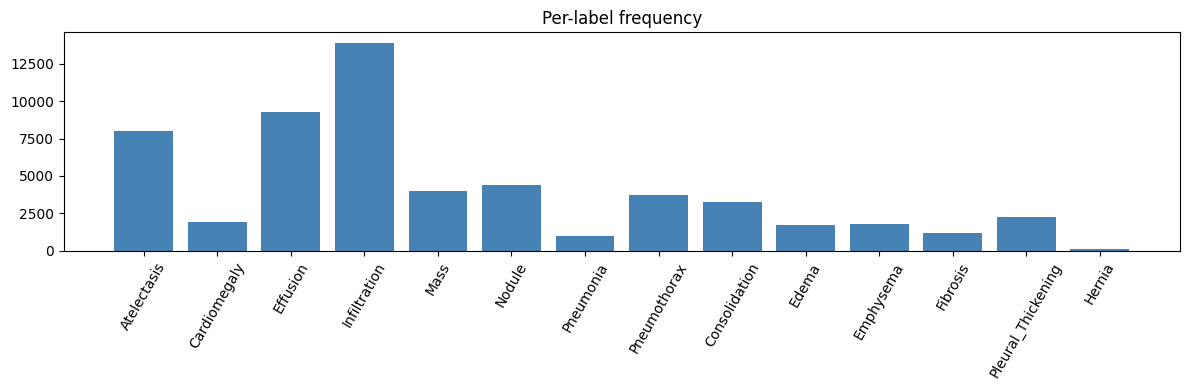

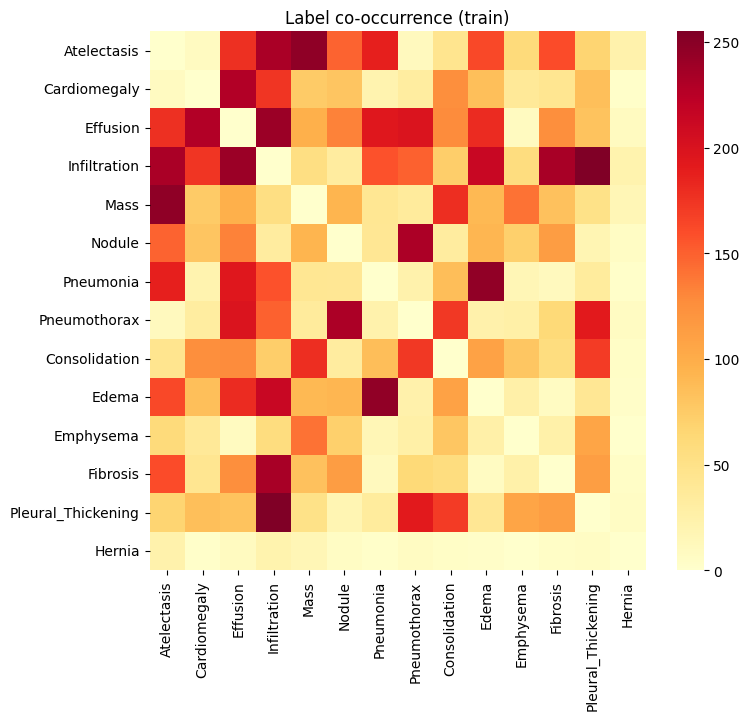

In [ ]:
#ANALYSIS: label prevalence and co-occurrence
print("Label frequencies (train):")
for i, c in enumerate(np.sum(y_train, axis=0)):
    print(f"{label_names[i]:20s} : {c}")
plt.figure(figsize=(12, 4))
plt.bar(label_names, np.sum(y_train,axis=0), color='steelblue')
plt.title("Per-label frequency")
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

co = np.dot(y_train.T, y_train)
np.fill_diagonal(co, 0)
plt.figure(figsize=(8, 7))
sns.heatmap(co, cmap="YlOrRd", xticklabels=label_names, yticklabels=label_names)
plt.title("Label co-occurrence (train)")
plt.show()


In [ ]:
#PREPROCESSING AND BALANCED SAMPLE
def preprocess(X):
    return X.reshape(X.shape[0], -1) / 255.0

X_train_proc = preprocess(X_train)
X_test_proc = preprocess(X_test)

sample_size = 40000
np.random.seed(42)
idx = np.random.choice(X_train_proc.shape[0], sample_size, replace=False)
X_sample, y_sample = X_train_proc[idx], y_train[idx]
print(f"Trained with: {X_sample.shape[0]} samples, Features: {X_sample.shape[1]}")


Trained with: 40000 samples, Features: 784


In [ ]:
#TRAIN MODELS (BinaryRelevance, Chain, Powerset)
br_clf = BinaryRelevance(LogisticRegression(max_iter=500, random_state=42, class_weight='balanced', n_jobs=-1))
br_clf.fit(X_sample, y_sample)
print("BR trained")

cc_clf = ClassifierChain(LogisticRegression(max_iter=500, random_state=42, class_weight='balanced', n_jobs=-1))
cc_clf.fit(X_sample, y_sample)
print("CC trained")

lp_clf = LabelPowerset(LogisticRegression(max_iter=500, random_state=42, class_weight='balanced', n_jobs=-1))
lp_clf.fit(X_sample, y_sample)
print("LP trained")


BR trained
CC trained
LP trained


In [ ]:
print(f"True avg labels/sample: {np.mean(np.sum(y_test, axis=1)):.2f}")


True avg labels/sample: 0.74


In [ ]:
def predict_with_threshold(classifier, X, threshold):
    # Get probability estimates from the classifier
    # Convert sparse matrix output from predict_proba to dense array if applicable
    proba = classifier.predict_proba(X)
    if hasattr(proba, 'toarray'):
        proba = proba.toarray()
    # Apply threshold to probabilities to get binary predictions
    return (proba >= threshold).astype(int)

for thresh in [0.2, 0.3, 0.4, 0.5, 0.6]:
    pred = predict_with_threshold(br_clf, X_test_proc, thresh)
    # Fix shape if needed!
    if pred.shape[0] != y_test.shape[0]:
        pred = pred.T
    avg = np.mean(np.sum(pred, axis=1))
    print(f"Threshold {thresh:.2f}: Avg labels/sample = {avg:.2f}")

print(f"\nTrue avg labels/sample: {np.mean(np.sum(y_test, axis=1)):.2f}")


Threshold 0.20: Avg labels/sample = 10.71
Threshold 0.30: Avg labels/sample = 8.81
Threshold 0.40: Avg labels/sample = 6.54
Threshold 0.50: Avg labels/sample = 4.27
Threshold 0.60: Avg labels/sample = 2.47

True avg labels/sample: 0.74


In [ ]:
best_thresh = 0.6

br_pred = predict_with_threshold(br_clf, X_test_proc, best_thresh)
if br_pred.shape[0] != y_test.shape[0]:
    br_pred = br_pred.T

cc_pred = predict_with_threshold(cc_clf, X_test_proc, best_thresh)
if cc_pred.shape[0] != y_test.shape[0]:
    cc_pred = cc_pred.T

lp_pred = predict_with_threshold(lp_clf, X_test_proc, best_thresh)
if lp_pred.shape[0] != y_test.shape[0]:
    lp_pred = lp_pred.T

print(f"Using threshold: {best_thresh}")
print(f"br_pred shape: {br_pred.shape}")
print(f"cc_pred shape: {cc_pred.shape}")
print(f"lp_pred shape: {lp_pred.shape}")
print(f"Avg predictions/sample (BR): {np.mean(np.sum(br_pred, axis=1)):.2f}")

Using threshold: 0.6
br_pred shape: (22433, 14)
cc_pred shape: (22433, 14)
lp_pred shape: (22433, 14)
Avg predictions/sample (BR): 2.47


In [ ]:
#EVALUATE MODELS
def eval_model(y_true, y_pred):
    if y_pred.shape[0]!=y_true.shape[0]: y_pred = y_pred.T
    return {
        'Hamming': hamming_loss(y_true, y_pred),
        'Jaccard': jaccard_score(y_true, y_pred, average='samples', zero_division=0),
        'F1-Micro': f1_score(y_true, y_pred, average='micro', zero_division=0),
        'F1-Macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'Precision': precision_score(y_true, y_pred, average='micro', zero_division=0),
        'Recall': recall_score(y_true, y_pred, average='micro', zero_division=0)
    }

results = {
    'Binary Relevance': eval_model(y_test, br_pred),
    'Classifier Chain': eval_model(y_test, cc_pred),
    'Label Powerset': eval_model(y_test, lp_pred)
}
df = pd.DataFrame(results).T
print(df.round(4).to_string())
best = df['F1-Micro'].idxmax()
print(f"\nBest model: {best} (F1={df.loc[best, 'F1-Micro']:.3f})")

                  Hamming  Jaccard  F1-Micro  F1-Macro  Precision  Recall
Binary Relevance   0.1913   0.0579    0.1635    0.1345     0.1062  0.3557
Classifier Chain   0.3260   0.0580    0.1505    0.1290     0.0872  0.5494
Label Powerset     0.0638   0.0171    0.0736    0.0419     0.1558  0.0482

Best model: Binary Relevance (F1=0.164)


In [ ]:
#PER-LABEL METRICS
best_pred = br_pred if best == 'Binary Relevance' else (cc_pred if best == 'Classifier Chain' else lp_pred)
if best_pred.shape[0]!=y_test.shape[0]: best_pred = best_pred.T

label_results = []
for i, name in enumerate(label_names):
    f1 = f1_score(y_test[:,i], best_pred[:,i], zero_division=0)
    prec = precision_score(y_test[:,i], best_pred[:,i], zero_division=0)
    rec = recall_score(y_test[:,i], best_pred[:,i], zero_division=0)
    label_results.append({'Disease': name, 'F1': f1, 'Precision':prec, 'Recall': rec})
label_df = pd.DataFrame(label_results).sort_values('F1', ascending=False)
print(label_df.to_string(index=False))

           Disease       F1  Precision   Recall
          Effusion 0.342135   0.262352 0.491649
      Infiltration 0.287407   0.279673 0.295582
       Atelectasis 0.261940   0.193670 0.404545
     Consolidation 0.153143   0.092802 0.437827
      Pneumothorax 0.138216   0.086874 0.337925
      Cardiomegaly 0.115546   0.065821 0.472509
              Mass 0.115172   0.075847 0.239188
            Nodule 0.107029   0.074689 0.188764
             Edema 0.101995   0.056264 0.544794
Pleural_Thickening 0.091375   0.054177 0.291553
         Emphysema 0.061939   0.034747 0.284872
          Fibrosis 0.059322   0.032424 0.348066
         Pneumonia 0.035280   0.018720 0.305785
            Hernia 0.012313   0.006393 0.166667


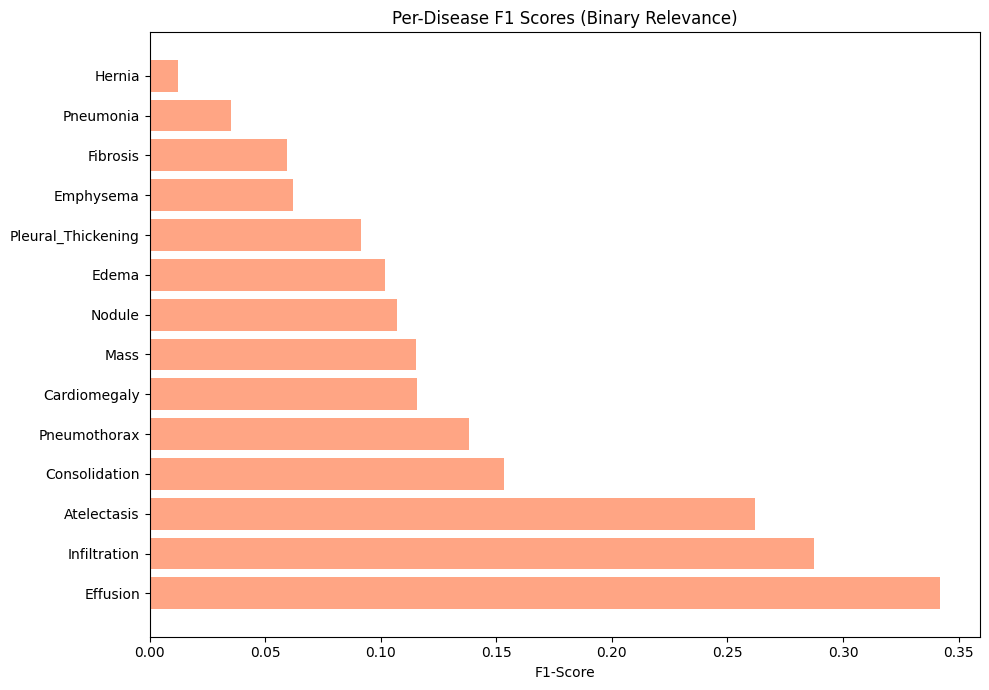

In [ ]:
#VISUALIZE RESULTS
fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(label_df['Disease'], label_df['F1'], color='coral', alpha=0.7)
ax.set_xlabel('F1-Score')
ax.set_title(f'Per-Disease F1 Scores ({best})')
plt.tight_layout()
plt.show()

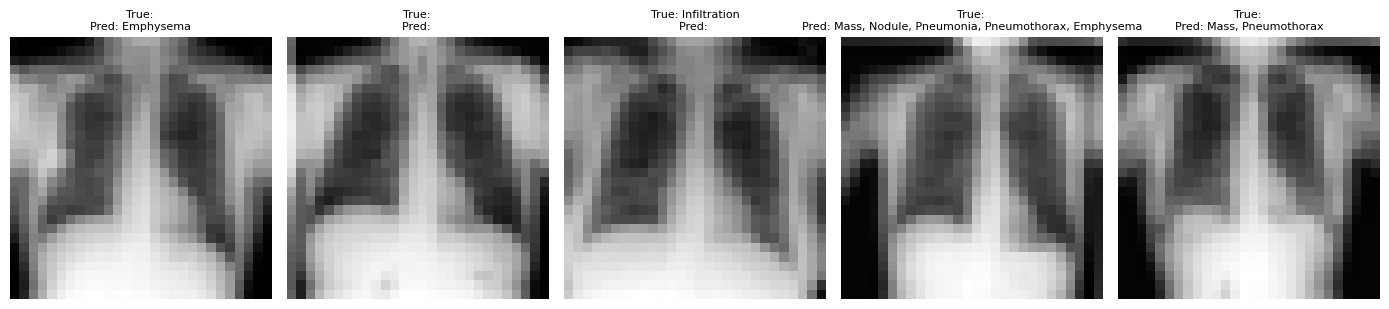

In [ ]:
#SAMPLE PREDICTIONS
def show_samples(X, y_true, y_pred, n=5):
    fig, axes = plt.subplots(1, n, figsize=(14, 3))
    for i in range(n):
        axes[i].imshow(X[i], cmap='gray')
        true = [label_names[j] for j in range(14) if y_true[i, j]]
        pred = [label_names[j] for j in range(14) if y_pred[i, j]]
        axes[i].set_title(f"True: {', '.join(true)}\nPred: {', '.join(pred)}", fontsize=8)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_samples(X_test, y_test, best_pred, n=5)

In [ ]:
#SUMMARY
print("="*60)
print("PROJECT SUMMARY")
print("="*60)
print(f"Dataset: ChestMNIST ({X_train.shape[0]:,} train, {X_test.shape[0]:,} test)")
print(f"Task: Multi-label classification ({y_train.shape[1]} diseases)")
print(f"Training samples used: {sample_size:,}\n")
print(f"Best algorithm: {best}")
print(f"F1-Micro: {df.loc[best, 'F1-Micro']:.4f}")
print(f"F1-Macro: {df.loc[best, 'F1-Macro']:.4f}")
print(f"Hamming Loss: {df.loc[best, 'Hamming']:.4f}")
print("="*60)

PROJECT SUMMARY
Dataset: ChestMNIST (78,468 train, 22,433 test)
Task: Multi-label classification (14 diseases)
Training samples used: 40,000

Best algorithm: Binary Relevance
F1-Micro: 0.1635
F1-Macro: 0.1345
Hamming Loss: 0.1913
